In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import json

import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import random
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import trimesh
from datetime import datetime 

from pointnet2_utils import PointNetSetAbstractionMsg, PointNetSetAbstraction
from pointnet2_keypoint_regressor import get_model#, get_model_msg

from torch.utils.data import random_split

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [4]:
class KeypointPredictor:
    def __init__(self, model_path, device='cuda'):
        """
        Initialize the keypoint predictor
        
        Args:
            model_path: path to saved model (.pth file)
            device: 'cuda' or 'cpu'
        """

        random.seed(0)
        np.random.seed(0)
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load model checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        self.config = checkpoint.get('config', {'num_keypoints': 9, 'num_points': 1024})
        
        # Initialize model
        self.model = get_model(
            num_keypoints=self.config['num_keypoints'], 
            normal_channel=False
        ).to(self.device)
        
        # Load trained weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        #print(f"Loaded model with {self.config['num_keypoints']} keypoints")
        #print(f"Using device: {self.device}")
    
    def load_and_sample_mesh(self, mesh_path, num_points=None):
        """
        Load mesh and sample points from surface
        
        Args:
            mesh_path: path to mesh file (.ply, .obj, etc.)
            num_points: number of points to sample (default: from config)
        
        Returns:
            points: numpy array of shape (num_points, 3)
        """
        if num_points is None:
            num_points = self.config['num_points']
        
        try:
            # Load mesh
            mesh = trimesh.load(mesh_path, force='mesh')
            if mesh.is_empty or len(mesh.faces) == 0:
                raise ValueError("Empty mesh")
            
            # Sample points from surface
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            
            # Handle case where mesh has fewer faces than requested points
            if points.shape[0] < num_points:
                pad_size = num_points - points.shape[0]
                pad = np.repeat(points[0:1, :], pad_size, axis=0)
                points = np.vstack((points, pad))
            
            return points.astype(np.float32)
            
        except Exception as e:
            print(f"Error loading mesh {mesh_path}: {e}")
            return None
    
    def normalize_points(self, points):
        """
        Normalize points using same method as training
        
        Args:
            points: numpy array of shape (num_points, 3)
        
        Returns:
            normalized_points: numpy array of shape (num_points, 3)
            centroid: numpy array of shape (3,) - for denormalization
            scale: float - for denormalization
        """
        centroid = np.mean(points, axis=0)
        scale = np.max(np.linalg.norm(points - centroid, axis=1))
        
        # Avoid division by zero
        if scale == 0:
            scale = 1.0
        
        normalized_points = (points - centroid) / scale
        return normalized_points, centroid, scale
    
    def denormalize_keypoints(self, keypoints, centroid, scale):
        """
        Convert normalized keypoints back to original coordinate system
        
        Args:
            keypoints: numpy array of shape (num_keypoints, 3)
            centroid: numpy array of shape (3,)
            scale: float
        
        Returns:
            denormalized_keypoints: numpy array of shape (num_keypoints, 3)
        """
        return keypoints * scale + centroid
    
    def predict_keypoints(self, mesh_path, return_normalized=False):
        """
        Predict keypoints for a single mesh
        
        Args:
            mesh_path: path to mesh file
            return_normalized: if True, return keypoints in normalized coordinates
        
        Returns:
            keypoints: numpy array of shape (num_keypoints, 3)
            points: numpy array of shape (num_points, 3) - sampled points
            metadata: dict with normalization info
        """
        # Load and sample mesh
        points = self.load_and_sample_mesh(mesh_path)
        if points is None:
            return None, None, None
        
        # Normalize points
        normalized_points, centroid, scale = self.normalize_points(points)
        
        # Convert to tensor and add batch dimension
        points_tensor = torch.from_numpy(normalized_points).float()
        points_tensor = points_tensor.unsqueeze(0).permute(0, 2, 1).to(self.device)  # Shape: (1, 3, num_points)
        
        # Predict keypoints
        with torch.no_grad():
            predicted_keypoints, _ = self.model(points_tensor)
        
        # Convert back to numpy
        predicted_keypoints = predicted_keypoints.squeeze(0).cpu().numpy()  # Shape: (num_keypoints, 3)
        
        # Denormalize if requested
        if not return_normalized:
            predicted_keypoints = self.denormalize_keypoints(predicted_keypoints, centroid, scale)
            points_for_vis = points  # Original points
        else:
            points_for_vis = normalized_points
        
        metadata = {
            'centroid': centroid,
            'scale': scale,
            'mesh_path': mesh_path
        }
        
        return predicted_keypoints, points_for_vis, metadata
    
    def predict_batch(self, mesh_paths, return_normalized=False):
        """
        Predict keypoints for multiple meshes
        
        Args:
            mesh_paths: list of paths to mesh files
            return_normalized: if True, return keypoints in normalized coordinates
        
        Returns:
            results: list of (keypoints, points, metadata) tuples
        """
        results = []
        for mesh_path in mesh_paths:
            result = self.predict_keypoints(mesh_path, return_normalized)
            results.append(result)
        return results




In [5]:
def visualize_keypoints_3d(points, keypoints, title="Predicted Keypoints", figsize=(12, 8)):
    """
    Visualize point cloud with predicted keypoints
    
    Args:
        points: numpy array of shape (num_points, 3)
        keypoints: numpy array of shape (num_keypoints, 3)
        title: string
        figsize: tuple for figure size
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot point cloud
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
               c='lightblue', alpha=0.6, s=1, label='Point Cloud')
    
    # Plot keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], 
               c='red', s=100, label='Predicted Keypoints', marker='o')
    
    # Add keypoint numbers
    for i, kp in enumerate(keypoints):
        ax.text(kp[0], kp[1], kp[2], f'  {i}', fontsize=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    
    # Set equal aspect ratio
    max_range = np.array([points[:, 0].max()-points[:, 0].min(),
                         points[:, 1].max()-points[:, 1].min(),
                         points[:, 2].max()-points[:, 2].min()]).max() / 2.0
    mid_x = (points[:, 0].max()+points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max()+points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max()+points[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.view_init(elev=-90, azim=90)
    
    plt.show()



In [6]:
def predict_points(model_path, input_ply, verbose = False, visualize = False, save = False):
    predictor = KeypointPredictor(model_path)

    mesh_path = input_ply 
    keypoints, points, metadata = predictor.predict_keypoints(mesh_path)

    if keypoints is not None:
        if verbose:
            print(f"Predicted {len(keypoints)} keypoints for {mesh_path}")
            print("Keypoints coordinates:")
        
        #for i, kp in enumerate(keypoints):
        #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")

        return keypoints[0], keypoints[1]

        
        # Visualize results
        if visualize:
            visualize_keypoints_3d(points, keypoints, f"Keypoints for {os.path.basename(mesh_path)}")        
        
        # Save keypoints to file
        if save:
            output_path = mesh_path.replace('.ply', '_keypoints.txt')
            save_keypoints_to_file(keypoints, output_path, mesh_path)
    else:
        print(f"Failed to process {mesh_path}")

    


In [8]:
predict_points("Old_Architecture/saved_models/kneenet++_4_5_final_2.pth", "scans_2/12252.stl")

(TrackedArray([-0.16309746,  0.35827634, -0.50816125], dtype=float32),
 TrackedArray([-0.16734046,  0.03024679, -0.5564809 ], dtype=float32))

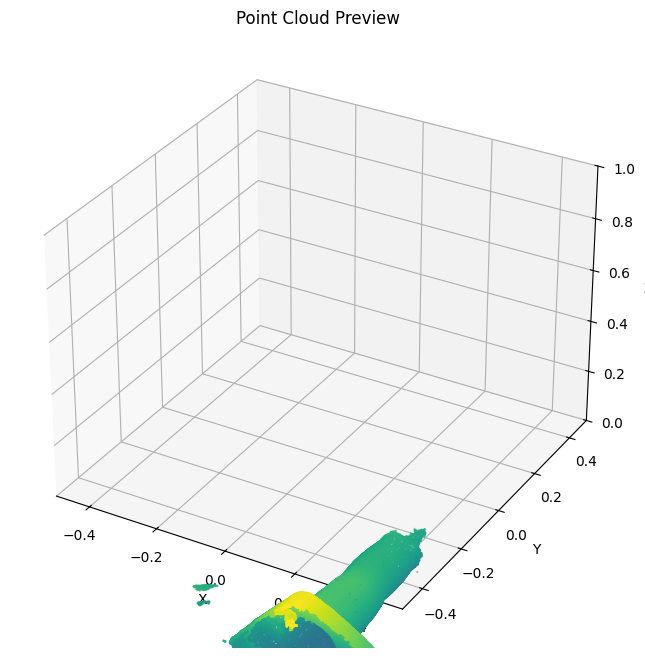

In [9]:
# Load STL mesh
scan_id = "12197"
mesh = o3d.io.read_triangle_mesh("scans_3/" + scan_id + ".stl")
mesh.compute_vertex_normals()

# Sample points on the mesh surface
pcd = mesh.sample_points_uniformly(number_of_points=60000)  # adjust as needed



raw_points = np.asarray(pcd.points)

# Create matplotlib 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
           c=raw_points[:, 2], cmap='viridis', s=0.5)

ax.set_title('Point Cloud Preview')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0, 1)

plt.show()

In [7]:
def load_annotations(annotation_file):
    with open(annotation_file, "r") as f:
        annotations = json.load(f)
    
    model_id_to_keypoints = {}
    for entry in annotations:
        model_id = entry["model_id"]
        keypoints = entry["keypoints"]
        model_id_to_keypoints[model_id] = [kp["xyz"] for kp in keypoints]
    
    return model_id_to_keypoints


def get_keypoints_for_model(model_id, annotation_file):
    model_id_to_keypoints = load_annotations(annotation_file)
    
    if model_id in model_id_to_keypoints:
        return model_id_to_keypoints[model_id]
    else:
        print(f"Model ID {model_id} not found in annotations.")
        return None

In [14]:
def filter_mesh(scan_id, model_dir = "Old_Architecture/saved_models/kneenet++_4_5_final_2.pth"):
    #mesh = o3d.io.read_triangle_mesh("scans_2/" + scan_id + ".stl")

    mesh = o3d.io.read_triangle_mesh("scans_3_aug/" + scan_id + ".stl")
    mesh.compute_vertex_normals()
    # Sample points on the mesh surface
    pcd = mesh.sample_points_uniformly(number_of_points=100000)  # adjust as needed

    raw_points = np.asarray(pcd.points)


    print("Scan ID: " + scan_id)

    kp1, kp2 = predict_points(model_dir, "scans_3_aug/"+ scan_id + ".stl")

    '''
    annotation_file = "knee_annotations/knees_4_5_aug_flipped.json"  # Path to your annotation file
    keypoints = get_keypoints_for_model(scan_id, annotation_file)
    if keypoints:
        #for i, kp in enumerate(keypoints):
        #    print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
        thigh_point = np.array(keypoints[0])
        shin_point = np.array(keypoints[1])

    #print(thigh_point)

    '''

    thigh_point = np.array(kp1)
    shin_point = np.array(kp2)

    # Example: your model predicts these two points (numpy arrays)
    #thigh_point = np.array([-0.163, 0.358, -0.508])
    #shin_point  = np.array([-0.167, 0.030, -0.556])

    #-0.163 0.358 -0.508
    #-0.167 0.030 -0.556

    #-0.055 -0.140 0.478
    #-0.071 0.218 0.495

    # Compute leg axis vector
    axis_vec = shin_point - thigh_point
    axis_unit = axis_vec / np.linalg.norm(axis_vec)

    # Transform all points into axis coordinates
    points = np.asarray(pcd.points)

    vec_to_points = points - thigh_point  # vectors from thigh point to all points

    # Project vectors onto axis to get "height" along the axis
    heights = vec_to_points @ axis_unit  # dot product

    # Compute radial distance from axis line
    proj_points = np.outer(heights, axis_unit)  # projection vectors
    radial_vecs = vec_to_points - proj_points
    radii = np.linalg.norm(radial_vecs, axis=1)

    # Define crop region
    height_min = -20  # mm or units below thigh point
    height_max = np.linalg.norm(axis_vec) + 20  # mm above shin point
    radius_max = 60  # adjust as needed <<<<


    height_min = -100
    height_max = np.linalg.norm(axis_vec) + 100 
    radius_max = 10


    print(f"Max height: {np.max(heights):.2f}")
    print(f"Max radius: {np.max(radii):.2f}")

    # Example dynamic crop
    height_min = np.min(heights) + 0.05
    height_max = np.max(heights) - 0.05
    radius_max = np.max(radii) - 0.1 #- 0.2

    # Jeet
    height_min = np.min(heights) + 0.1
    height_max = np.max(heights) - 0.15

    offset = min(0.4, np.max(radii) * 0.5)
    radius_max = np.max(radii) - offset
    radius_max = max(radius_max, 0)  # Don’t go negative



    # Create a mask for points inside cylinder
    mask = (
        (heights >= height_min) &
        (heights <= height_max) &
        (radii <= radius_max)
    )

    # Crop the point cloud
    cropped_points = points[mask]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(cropped_points)

    print(f"axis_unit: {axis_unit}")
    print(f"heights: min={np.min(heights):.2f}, max={np.max(heights):.2f}")
    print(f"radii: min={np.min(radii):.2f}, max={np.max(radii):.2f}")
    print(f"height range: [{height_min}, {height_max}], radius_max: {radius_max}")
    print(f"Points before mask: {len(points)}, after mask: {np.sum(mask)}")


    '''
    # Create matplotlib 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
            c=points[:, 2], cmap='viridis', s=0.5)

    ax.set_title('Point Cloud Preview')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()
    '''



    points_cropped = np.asarray(cropped_pcd.points)
    '''
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()
    '''

    #print(f"Before crop: {len(points)} points")
    #print(f"After crop: {len(cropped_points)} points")

    # Optionally apply radius outlier removal to remove isolated noise
    # (You can also use DBSCAN or connected components)

    #cl, ind = cropped_pcd.remove_radius_outlier(nb_points=64, radius=0.05) # radius based filtering
    
    #cl, ind = cropped_pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 1.2) #statitical based filtered (not good)
    #cleaned_pcd = cropped_pcd.select_by_index(ind)



    labels = np.array(cropped_pcd.cluster_dbscan(eps=0.01, min_points=20, print_progress=True))

    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

    largest_cluster_label = unique_labels[np.argmax(counts)]

    indices = np.where(labels == largest_cluster_label)[0]

    cleaned_pcd = cropped_pcd.select_by_index(indices)

    print(f"After outlier removal: {len(cleaned_pcd.points)} points")




    fig = plt.figure(figsize=(10, 8))
   
   
   
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
            c=raw_points[:, 2], cmap='viridis', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()


    cleaned_points = np.asarray(cleaned_pcd.points) # Only need this for radius filtering

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(cleaned_points[:, 0], cleaned_points[:, 1], cleaned_points[:, 2],
            c=cleaned_points[:, 2], cmap='cool', s=0.5)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()

    return cleaned_pcd


Scan ID: 12194_aug_1
Max height: 0.47
Max radius: 0.61
axis_unit: [-0.1916321   0.9218662  -0.33680838]
heights: min=-0.32, max=0.47
radii: min=0.00, max=0.61
height range: [-0.22360517743278643, 0.3237414837581627], radius_max: 0.3057397991517726
Points before mask: 100000, after mask: 81558
Precompute neighbors.[========================================] 100%
ClusteringAfter outlier removal: 81549 points      ] 15%


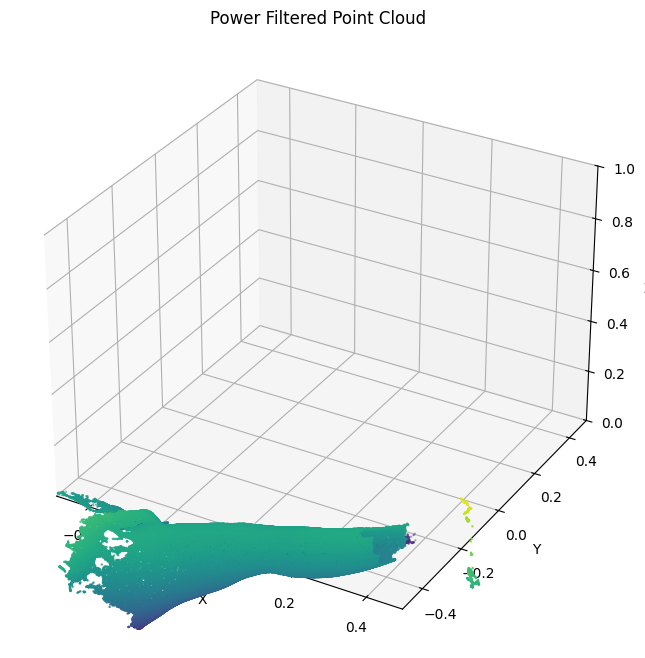

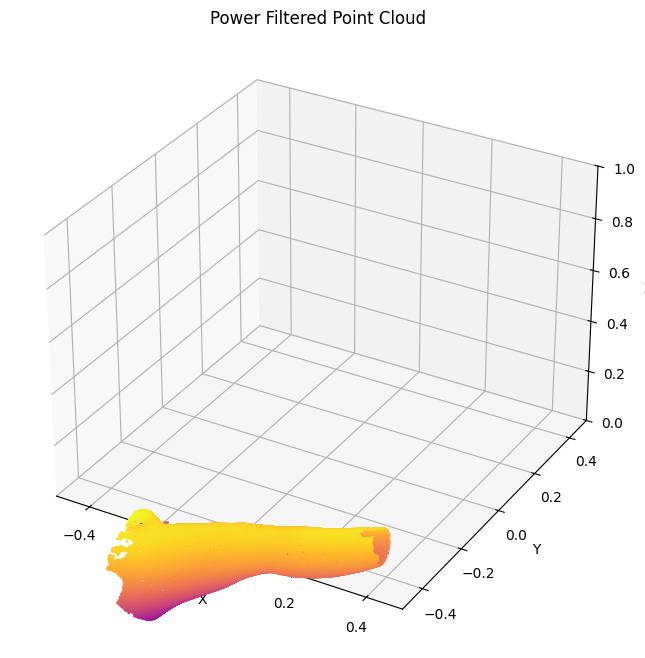

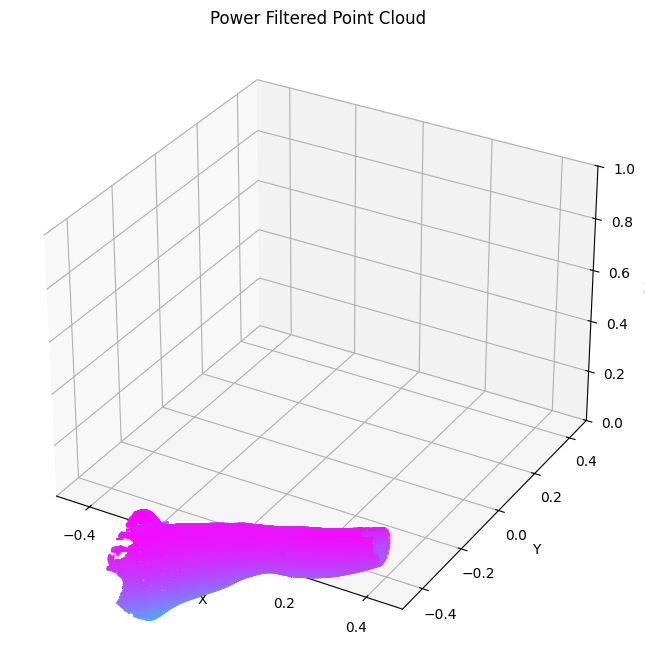

In [17]:
cleaned_pcd = filter_mesh("12194_aug_1")

In [18]:
# Save to a PLY file
o3d.io.write_point_cloud("filtered_point_cloud.ply", cleaned_pcd)

True